## Inception V3

In [25]:

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torchsummary import summary
from datetime import datetime

!pip3 install torchviz
from torchviz import make_dot

## 1. Building the model

### Basic Convolution Block

In [26]:
class BasicConv2d(nn.Module):
    """ Basic conv batchnorm relu """
    def __init__(self, input_channels, output_channels, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        return x

### Naive Inception Module

In [27]:
class InceptionA(nn.Module):
    """ Naive Inception Block """
    def __init__(self, input_channels, pool_features):
        super().__init__()
        self.branch1x1 = BasicConv2d(input_channels, 64, kernel_size=1)

        self.branch5x5 = nn.Sequential(
            BasicConv2d(input_channels, 48, kernel_size=1),
            BasicConv2d(48, 64, kernel_size=5, padding=2)
        )

        self.branch3x3 = nn.Sequential(
            BasicConv2d(input_channels, 64, kernel_size=1),
            BasicConv2d(64, 96, kernel_size=3, padding=1),
            BasicConv2d(96, 96, kernel_size=3, padding=1)
        )

        self.branchpool = nn.Sequential(
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(input_channels, pool_features, kernel_size=3, padding=1)
        )

    def forward(self, x):

        #x -> 1x1(same)
        branch1x1 = self.branch1x1(x)

        #x -> 1x1 -> 5x5(same)
        branch5x5 = self.branch5x5(x)

        #x -> 1x1 -> 3x3 -> 3x3(same)
        branch3x3 = self.branch3x3(x)

        #x -> pool -> 1x1(same)
        branchpool = self.branchpool(x)

        outputs = [branch1x1, branch5x5, branch3x3, branchpool]

        return torch.cat(outputs, 1)


### Factorization into smaller convolution

In [28]:
class InceptionB(nn.Module):
    def __init__(self, input_channels):
        super().__init__()

        self.branch3x3 = BasicConv2d(input_channels, 384, kernel_size=3, stride=2)

        self.branch3x3stack = nn.Sequential(
            BasicConv2d(input_channels, 64, kernel_size=1),
            BasicConv2d(64, 96, kernel_size=3, padding=1),
            BasicConv2d(96, 96, kernel_size=3, stride=2)
        )

        self.branchpool = nn.MaxPool2d(kernel_size=3, stride=2)

    def forward(self, x):

        #x - > 3x3(downsample)
        branch3x3 = self.branch3x3(x)

        #x -> 3x3 -> 3x3(downsample)
        branch3x3stack = self.branch3x3stack(x)

        #x -> avgpool(downsample)
        branchpool = self.branchpool(x)

        #"""We can use two parallel stride 2 blocks: P and C. P is a pooling
        #layer (either average or maximum pooling) the activation, both of
        #them are stride 2 the filter banks of which are concatenated as in
        #figure 10."""
        outputs = [branch3x3, branch3x3stack, branchpool]

        return torch.cat(outputs, 1)


### Factorizing Convolutions with Large Filter Size

In [29]:
class InceptionC(nn.Module):
    def __init__(self, input_channels, channels_7x7):
        super().__init__()
        self.branch1x1 = BasicConv2d(input_channels, 192, kernel_size=1)

        c7 = channels_7x7

        #In theory, we could go even further and argue that one can replace any n × n
        #convolution by a 1 × n convolution followed by a n × 1 convolution and the
        #computational cost saving increases dramatically as n grows (see figure 6).
        self.branch7x7 = nn.Sequential(
            BasicConv2d(input_channels, c7, kernel_size=1),
            BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0)),
            BasicConv2d(c7, 192, kernel_size=(1, 7), padding=(0, 3))
        )

        self.branch7x7stack = nn.Sequential(
            BasicConv2d(input_channels, c7, kernel_size=1),
            BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0)),
            BasicConv2d(c7, c7, kernel_size=(1, 7), padding=(0, 3)),
            BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0)),
            BasicConv2d(c7, 192, kernel_size=(1, 7), padding=(0, 3))
        )

        self.branch_pool = nn.Sequential(
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(input_channels, 192, kernel_size=1),
        )

    def forward(self, x):

        #x -> 1x1(same)
        branch1x1 = self.branch1x1(x)

        #x -> 1layer 1*7 and 7*1 (same)
        branch7x7 = self.branch7x7(x)

        #x-> 2layer 1*7 and 7*1(same)
        branch7x7stack = self.branch7x7stack(x)

        #x-> avgpool (same)
        branchpool = self.branch_pool(x)

        outputs = [branch1x1, branch7x7, branch7x7stack, branchpool]

        return torch.cat(outputs, 1)


In [30]:
class InceptionD(nn.Module):

    def __init__(self, input_channels):
        super().__init__()

        self.branch3x3 = nn.Sequential(
            BasicConv2d(input_channels, 192, kernel_size=1),
            BasicConv2d(192, 320, kernel_size=3, stride=2)
        )

        self.branch7x7 = nn.Sequential(
            BasicConv2d(input_channels, 192, kernel_size=1),
            BasicConv2d(192, 192, kernel_size=(1, 7), padding=(0, 3)),
            BasicConv2d(192, 192, kernel_size=(7, 1), padding=(3, 0)),
            BasicConv2d(192, 192, kernel_size=3, stride=2)
        )

        self.branchpool = nn.AvgPool2d(kernel_size=3, stride=2)

    def forward(self, x):

        #x -> 1x1 -> 3x3(downsample)
        branch3x3 = self.branch3x3(x)

        #x -> 1x1 -> 1x7 -> 7x1 -> 3x3 (downsample)
        branch7x7 = self.branch7x7(x)

        #x -> avgpool (downsample)
        branchpool = self.branchpool(x)

        outputs = [branch3x3, branch7x7, branchpool]

        return torch.cat(outputs, 1)


In [31]:
class InceptionE(nn.Module):
    def __init__(self, input_channels):
        super().__init__()
        self.branch1x1 = BasicConv2d(input_channels, 320, kernel_size=1)

        self.branch3x3_1 = BasicConv2d(input_channels, 384, kernel_size=1)
        self.branch3x3_2a = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3_2b = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch3x3stack_1 = BasicConv2d(input_channels, 448, kernel_size=1)
        self.branch3x3stack_2 = BasicConv2d(448, 384, kernel_size=3, padding=1)
        self.branch3x3stack_3a = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3stack_3b = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch_pool = nn.Sequential(
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(input_channels, 192, kernel_size=1)
        )

    def forward(self, x):

        #x -> 1x1 (same)
        branch1x1 = self.branch1x1(x)

        # x -> 1x1 -> 3x1
        # x -> 1x1 -> 1x3
        # concatenate(3x1, 1x3)
        #"""7. Inception modules with expanded the filter bank outputs.
        #This architecture is used on the coarsest (8 × 8) grids to promote
        #high dimensional representations, as suggested by principle
        #2 of Section 2."""
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3)
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        # x -> 1x1 -> 3x3 -> 1x3
        # x -> 1x1 -> 3x3 -> 3x1
        #concatenate(1x3, 3x1)
        branch3x3stack = self.branch3x3stack_1(x)
        branch3x3stack = self.branch3x3stack_2(branch3x3stack)
        branch3x3stack = [
            self.branch3x3stack_3a(branch3x3stack),
            self.branch3x3stack_3b(branch3x3stack)
        ]
        branch3x3stack = torch.cat(branch3x3stack, 1)

        branchpool = self.branch_pool(x)

        outputs = [branch1x1, branch3x3, branch3x3stack, branchpool]

        return torch.cat(outputs, 1)


In [49]:
class InceptionV3(nn.Module):

    def __init__(self, num_classes=100):
        super().__init__()
        self.Conv2d_1a_3x3 = BasicConv2d(3, 32, kernel_size=3, padding=1)
        self.Conv2d_2a_3x3 = BasicConv2d(32, 32, kernel_size=3, padding=1)
        self.Conv2d_2b_3x3 = BasicConv2d(32, 64, kernel_size=3, padding=1)
        self.Conv2d_3b_1x1 = BasicConv2d(64, 80, kernel_size=1)
        self.Conv2d_4a_3x3 = BasicConv2d(80, 192, kernel_size=3)

        #naive inception module
        self.Mixed_5b = InceptionA(192, pool_features=32)
        self.Mixed_5c = InceptionA(256, pool_features=64)
        self.Mixed_5d = InceptionA(288, pool_features=64)

        #downsample
        self.Mixed_6a = InceptionB(288)

        self.Mixed_6b = InceptionC(768, channels_7x7=128)
        self.Mixed_6c = InceptionC(768, channels_7x7=160)
        self.Mixed_6d = InceptionC(768, channels_7x7=160)
        self.Mixed_6e = InceptionC(768, channels_7x7=192)

        #downsample
        self.Mixed_7a = InceptionD(768)

        self.Mixed_7b = InceptionE(1280)
        self.Mixed_7c = InceptionE(2048)

        #6*6 feature size
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout2d()
        self.linear = nn.Linear(2048, num_classes)

    def forward(self, x):

        #32 -> 30
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)

        #30 -> 30
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)

        #30 -> 14
        #Efficient Grid Size Reduction to avoid representation
        #bottleneck
        x = self.Mixed_6a(x)

        #14 -> 14
        #"""In practice, we have found that employing this factorization does not
        #work well on early layers, but it gives very good results on medium
        #grid-sizes (On m × m feature maps, where m ranges between 12 and 20).
        #On that level, very good results can be achieved by using 1 × 7 convolutions
        #followed by 7 × 1 convolutions."""
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)

        #14 -> 6
        #Efficient Grid Size Reduction
        x = self.Mixed_7a(x)

        #6 -> 6
        #We are using this solution only on the coarsest grid,
        #since that is the place where producing high dimensional
        #sparse representation is the most critical as the ratio of
        #local processing (by 1 × 1 convolutions) is increased compared
        #to the spatial aggregation."""
        x = self.Mixed_7b(x)
        x = self.Mixed_7c(x)

        #6 -> 1
        x = self.avgpool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        logits = self.linear(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs


In [50]:
net = InceptionV3()

In [51]:
print(net)

InceptionV3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (Conv2d_4a_3x3

In [52]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cpu')
print(device)

cuda


In [53]:
net = net.to(device)

In [54]:
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark = True

In [55]:
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
       BasicConv2d-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
       BasicConv2d-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          18,432
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
      BasicConv2d-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 80, 32, 32]           5,120
      BatchNorm2d-14           [-1, 80,

### 2) Data Preparation

In [56]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [66]:
train_set = torchvision.datasets.CIFAR10('./datasets', train=True, 
                                         download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10('./datasets', train=False, 
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, 
                                           shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, 
                                          shuffle=False, num_workers=4)


Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified


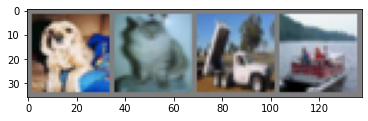

In [67]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()
    
image_iter = iter(train_loader)
images, _ = image_iter.next()
imshow(torchvision.utils.make_grid(images[:4]))

In [74]:
lr = 1e-3
momentum = 0.9
weight_decay = 5e-4
epochs = 10

In [75]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay,  nesterov=True)

### 3) Training

In [76]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In [77]:
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [78]:

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [79]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    
    return model, optimizer, (train_losses, valid_losses)

In [ ]:
model, optimizer, _ = training_loop(net, criterion, optimizer, train_loader, test_loader, epochs, device)

10:59:12 --- Epoch: 0	Train loss: 1.7757	Valid loss: 1.4690	Train accuracy: 47.26	Valid accuracy: 46.24
11:07:53 --- Epoch: 1	Train loss: 1.2144	Valid loss: 1.1106	Train accuracy: 61.52	Valid accuracy: 59.81
